In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim import models
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df=pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [9]:
df.columns=['Sentiment','Sentence']
print(df.shape)
df.head()

(4845, 2)


,Sentiment,Sentence
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [10]:
df=df[df['Sentiment']!= 'neutral']
print(df.shape)
df.head()

(1967, 2)


,Sentiment,Sentence
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,positive,"For the last quarter of 2010 , Componenta 's n..."


positive    1363
negative     604
Name: Sentiment, dtype: int64


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

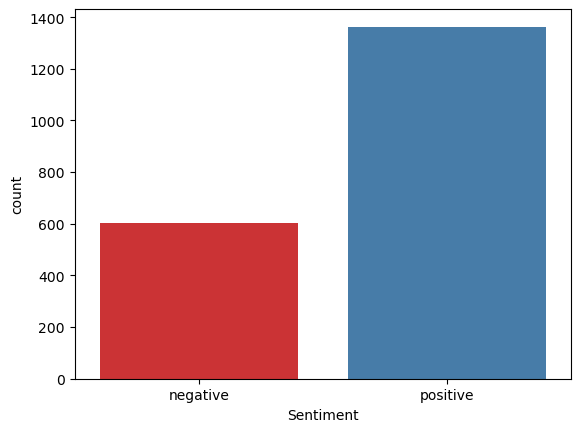

In [11]:
print(df['Sentiment'].value_counts())
sns.countplot(x='Sentiment',data=df, palette='Set1')

In [12]:
df['Sentiment']=df['Sentiment'].apply(lambda x: 0 if (x=='negative') else 1)
df.head()

,Sentiment,Sentence
1,0,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,1,"For the last quarter of 2010 , Componenta 's n..."


## Data Preprocessing

In [13]:
# deleting punctuations

import string
def del_punc(text):
    new_text=re.sub('['+string.punctuation+']', '', text)
    return new_text
df['Tokens']=df['Sentence'].apply(lambda x: del_punc(x))
df.head()

,Sentiment,Sentence,Tokens
1,0,The international electronic industry company ...,The international electronic industry company ...
2,1,With the new production plant the company woul...,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...,According to the company s updated strategy fo...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,FINANCING OF ASPOCOMP S GROWTH Aspocomp is agg...
5,1,"For the last quarter of 2010 , Componenta 's n...",For the last quarter of 2010 Componenta s net...


In [14]:
# Tokenizing the sentence

from nltk import word_tokenize

df['Tokens']=[word_tokenize(sen) for sen in df.Tokens]
df.head()

,Sentiment,Sentence,Tokens
1,0,The international electronic industry company ...,"[The, international, electronic, industry, com..."
2,1,With the new production plant the company woul...,"[With, the, new, production, plant, the, compa..."
3,1,According to the company 's updated strategy f...,"[According, to, the, company, s, updated, stra..."
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"[FINANCING, OF, ASPOCOMP, S, GROWTH, Aspocomp,..."
5,1,"For the last quarter of 2010 , Componenta 's n...","[For, the, last, quarter, of, 2010, Componenta..."


In [15]:
# converting to lower case

def to_lower(txt):
    return [t.lower() for t in txt]
df['Tokens']=[to_lower(txt) for txt in df.Tokens]
df.head()

,Sentiment,Sentence,Tokens
1,0,The international electronic industry company ...,"[the, international, electronic, industry, com..."
2,1,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa..."
3,1,According to the company 's updated strategy f...,"[according, to, the, company, s, updated, stra..."
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"[financing, of, aspocomp, s, growth, aspocomp,..."
5,1,"For the last quarter of 2010 , Componenta 's n...","[for, the, last, quarter, of, 2010, componenta..."


In [16]:
# removing stopwords

from nltk.corpus import stopwords

stopword_list=stopwords.words('english')
print(stopword_list)

def del_stop(txt):
    return [word for word in txt if word not in stopword_list]
fil_words=[del_stop(txt) for txt in df.Tokens]
df['new_sent']=[' '.join(sen) for sen in fil_words] 
df['Tokens']=[del_stop(txt) for txt in df.Tokens]
df=df[['Sentence','new_sent','Tokens','Sentiment']]
df.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,Sentence,new_sent,Tokens,Sentiment
1,The international electronic industry company ...,international electronic industry company elco...,"[international, electronic, industry, company,...",0
2,With the new production plant the company woul...,new production plant company would increase ca...,"[new, production, plant, company, would, incre...",1
3,According to the company 's updated strategy f...,according company updated strategy years 20092...,"[according, company, updated, strategy, years,...",1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing aspocomp growth aspocomp aggressivel...,"[financing, aspocomp, growth, aspocomp, aggres...",1
5,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,"[last, quarter, 2010, componenta, net, sales, ...",1


In [17]:
# One hot encoding the Sentiment column for 2D output vector

pos = []
neg = []
for l in df.Sentiment:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
df['Pos']= pos
df['Neg']= neg
df.head()

,Sentence,new_sent,Tokens,Sentiment,Pos,Neg
1,The international electronic industry company ...,international electronic industry company elco...,"[international, electronic, industry, company,...",0,0,1
2,With the new production plant the company woul...,new production plant company would increase ca...,"[new, production, plant, company, would, incre...",1,1,0
3,According to the company 's updated strategy f...,according company updated strategy years 20092...,"[according, company, updated, strategy, years,...",1,1,0
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing aspocomp growth aspocomp aggressivel...,"[financing, aspocomp, growth, aspocomp, aggres...",1,1,0
5,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,"[last, quarter, 2010, componenta, net, sales, ...",1,1,0


## Splitting Data into Training and Testing set

In [18]:
train, test = train_test_split(df, test_size=0.10, random_state=42)

# Training data
training_words=[words for sent in train['Tokens'] for words in sent]
train_sent_len=[len(words) for words in train['Tokens']]
train_vocabulary=sorted(list(set(training_words)))

print("Total no of TRAINING words: %d, Vocabulary size: %d"%(len(training_words),len(train_vocabulary)))
print("Length of longest sentence: %d"%max(train_sent_len))

print("\n")

# Testing data
testing_words=[words for sent in test['Tokens'] for words in sent]
test_sent_len=[len(words) for words in test['Tokens']]
test_vocabulary=sorted(list(set(testing_words)))

print("Total no of TESTING words: %d, Vocabulary size: %d"%(len(testing_words),len(test_vocabulary)))
print("Length of longest sentence: %d"%max(train_sent_len))

Total no of TRAINING words: 25288, Vocabulary size: 5734
Length of longest sentence: 35


Total no of TESTING words: 2611, Vocabulary size: 1313
Length of longest sentence: 35


## Transfer learning using Google News Word2Vec Model

In [19]:
word2vec_path = "/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz"
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [20]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

## Embedding

In [21]:
training_embeddings = get_word2vec_embeddings(w2v_model, train, generate_missing=True)

In [22]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

## Tokenizing and Padding Sequence

In [23]:
# tokenizing data

tokenizer = Tokenizer(num_words=len(train_vocabulary), lower=True, char_level=False)
tokenizer.fit_on_texts(train["new_sent"].tolist())
training_sequences = tokenizer.texts_to_sequences(train["new_sent"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 5734 unique tokens.


In [24]:
# padding data

train_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = w2v_model[word] if word in w2v_model else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(5735, 300)


In [26]:
test_sequences = tokenizer.texts_to_sequences(test["new_sent"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Defining CNN Model

In [27]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [28]:
label_names = ['Pos', 'Neg']
y_train = train[label_names].values
x_train = train_data
y_tr = y_train

In [29]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      1720500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

### Training CNN Model

In [30]:
num_epochs = 5
batch_size = 34

In [31]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/5
47/47 [==============================] - 5s 71ms/step - loss: 0.6309 - acc: 0.6849 - val_loss: 0.5529 - val_acc: 0.7288
Epoch 2/5
47/47 [==============================] - 3s 67ms/step - loss: 0.4715 - acc: 0.7615 - val_loss: 0.4094 - val_acc: 0.8079
Epoch 3/5
47/47 [==============================] - 3s 66ms/step - loss: 0.3136 - acc: 0.8694 - val_loss: 0.3200 - val_acc: 0.8418
Epoch 4/5
47/47 [==============================] - 3s 70ms/step - loss: 0.1822 - acc: 0.9297 - val_loss: 0.3051 - val_acc: 0.8531
Epoch 5/5
47/47 [==============================] - 3s 65ms/step - loss: 0.0930 - acc: 0.9749 - val_loss: 0.2905 - val_acc: 0.8531


### Testing CNN Model

In [41]:
predictions = model.predict(test_data, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 147ms/step


In [33]:
labels = [1, 0]

In [34]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [35]:
sum(test.Sentiment==prediction_labels)/len(prediction_labels)

0.8375634517766497

[Text(0.5, 3.722222222222216, 'Predicted'),
 Text(33.22222222222222, 0.5, 'Tested')]

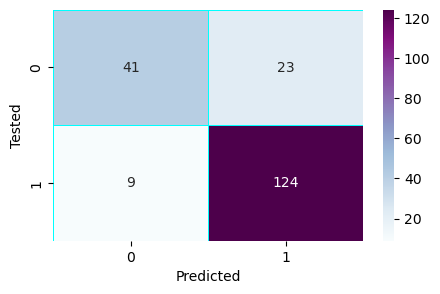

In [54]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(5,3))
cnn_val = confusion_matrix(test.Sentiment, prediction_labels)
ax=sns.heatmap(cnn_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', cmap="BuPu")
ax.set(xlabel="Predicted", ylabel="Tested")


### Test with new and different data set aside from the data to build the model.

note : sentiment = {'positive': 1,'negative':0}

In [42]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200, dtype='int32', value=0)
    prediction = model.predict(tw)
    print(prediction)
    print("Predicted label: ", labels[np.argmax(prediction)])

In [49]:
test_sentence1 = "One of the challenges in production in the Atlantic Sea is scale formation that can plug pipelines and halt production ."
predict_sentiment(test_sentence1)

test_sentence2 = "UniqueBoat was founded in 1998 , and its revenues have risen on an average by 45 % with margins in late 35s ."
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 24ms/step
[[0.15791136 0.8452353 ]]
Predicted label:  0
1/1 [==============================] - 0s 21ms/step
[[0.99851257 0.00156107]]
Predicted label:  1
